<a href="https://colab.research.google.com/github/sweetbaer03/KOR_Sentiment-Analysis/blob/main/%EB%84%A4%EC%9D%B4%EB%B2%84%EB%A6%AC%EB%B7%B0_LSTM(PyKomoran).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NSMC Sentiment Analysis**

LSTM 모델 사용 
(PyKomoran 형태소 분석 사용)

---
참고소스:
https://wikidocs.net/44249

https://skettee.github.io/post/long_short_term_memory/

In [1]:
#코모란 형태소 분석기 사용
!pip install PyKomoran

     |████████████████████████████████| 7.9MB 10.3MB/s 
     |████████████████████████████████| 204kB 52.1MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import time
import re
import os
import pickle
import datetime
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PyKomoran import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


github에서 필요한 데이터파일 다운

In [4]:
!git clone https://github.com/sweetbaer03/KOR_Sentiment-Analysis.git

Cloning into 'KOR_Sentiment-Analysis'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [6]:
# train/test set 데이터 로드
train_data = pd.read_csv("KOR_Sentiment-Analysis/data_in/ratings_train.txt", sep='\t')
test_tmp = pd.read_csv("KOR_Sentiment-Analysis/data_in/ratings_test.txt", sep='\t')

In [7]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
test_tmp[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [9]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_tmp)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000
테스트용 리뷰 개수 : 50000


## 캐글데이터 불러오기

In [10]:
test_csv = pd.read_csv('KOR_Sentiment-Analysis/data_in/ko_data.csv', encoding = 'cp949')
test_csv.head()

,Id,Sentence
0,0,정말 많이 울었던 영화입니다.
1,1,시간 낭비예요.
2,2,포스터를 저렇게밖에 만들지 못했던 제작자의 소심함에 침을 뱉고 싶다.
3,3,지금 봐도 재미있는 영화!!! 코믹과 감동!!! 그리고 요리!!!
4,4,이걸 영화로 만드는 거야?얼마나 가는지 보자.


# 데이터 정제하기

In [11]:
train_data.isnull().any()
test_tmp.isnull().any()

id          False
document     True
label       False
dtype: bool

In [12]:
train_data = train_data.dropna(axis=0).reset_index(drop=True)
test_tmp = test_tmp.dropna(axis=0).reset_index(drop=True)

In [13]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_tmp)) # 테스트용 리뷰 개수 출력

훈련용 리뷰 개수 : 149995
테스트용 리뷰 개수 : 49997


# 토큰화

In [14]:
train_data = train_data[['document', 'label']]
test_tmp = test_tmp[['document', 'label']]

In [15]:
print('Train data shape: ', train_data.shape)
n_lebel = len(train_data[train_data.label == 0])
print('Label 0 in Train data: {} ({:.1f}%)'.format(n_lebel, n_lebel*100/len(train_data)))
n_lebel = len(train_data[train_data.label == 1])
print('Label 1 in Train data: {} ({:.1f}%)'.format(n_lebel, n_lebel*100/len(train_data)))

print('\nTest data shape: ', test_tmp.shape)
n_lebel = len(test_tmp[test_tmp.label == 0])
print('Label 0 in Test data: {} ({:.1f}%)'.format(n_lebel, n_lebel*100/len(test_tmp)))
n_lebel = len(test_tmp[test_tmp.label == 1])
print('Label 1 in Test data: {} ({:.1f}%)'.format(n_lebel, n_lebel*100/len(test_tmp)))

Train data shape:  (149995, 2)
Label 0 in Train data: 75170 (50.1%)
Label 1 in Train data: 74825 (49.9%)

Test data shape:  (49997, 2)
Label 0 in Test data: 24826 (49.7%)
Label 1 in Test data: 25171 (50.3%)


In [16]:
komoran = Komoran("STABLE")
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH', 
                   'SW', 'NF', 'NV', 'SN', 'NA']

In [17]:
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.get_list(corpus)
    for pair in pairs:
        morph = pair.get_first()
        pos = pair.get_second()
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

In [18]:
tokens_list = []

for i in range(len(train_data['document'])):
    tokens_list.append(tokenize(train_data['document'][i], stop_pos_tags))

In [19]:
train_data['tokens'] = tokens_list
train_data.head()

,document,label,tokens
0,아 더빙.. 진짜 짜증나네요 목소리,0,"[더빙, 진짜, 짜증, 나다, 네요, 목소리]"
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[포스터, 초, 딩, 영화, 줄, 오버, 연기, 가볍다, 지, 않다, 구나]"
2,너무재밓었다그래서보는것을추천한다,0,[]
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[교도소, 이야기, 이다, 구먼, 솔직히, 재미, 없다, 평점, 조정]"
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[익살, 연기, 돋보이다, 었, 영화, 스파이, 더, 맨, 늙다, 어, 보이다, 하..."


In [20]:
train_data = train_data[train_data['tokens'].str.len() > 2]

In [21]:
tokens_list = []

for i in range(len(test_tmp['document'])):
    tokens_list.append(tokenize(test_tmp['document'][i], stop_pos_tags))
test_tmp['tokens'] = tokens_list

test_tmp.head()

,document,label,tokens
0,굳 ㅋ,1,[굳다]
1,GDNTOPCLASSINTHECLUB,0,[]
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"[뭐, 이, 평점, 들, 나쁘다, 지, 않다, 지만, 점, 짜리, 더더욱, 아니다,..."
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,"[지루, 지, 않다, 은데, 완전, 막장, 이다, 돈, 주다, 고, 보다]"
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,"[아니다, 었, 어도, 별, 다섯, 개, 주다, 었, 텐, 데, 왜, 나오다, 아서..."


In [22]:
test_tmp = test_tmp[test_tmp['tokens'].str.len() > 2]

In [23]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words, oov_token = True)
tokenizer.fit_on_texts(train_data.tokens)
train_data.tokens = tokenizer.texts_to_sequences(train_data.tokens)
test_tmp.tokens = tokenizer.texts_to_sequences(test_tmp.tokens)

In [24]:
train_data.head()

,document,label,tokens
0,아 더빙.. 진짜 짜증나네요 목소리,0,"[502, 31, 210, 66, 70, 716]"
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[489, 305, 236, 2, 172, 1294, 42, 717, 16, 34,..."
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[5551, 138, 3, 3988, 281, 87, 17, 46, 2881]"
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[6734, 42, 845, 10, 2, 1602, 67, 414, 1156, 12..."
5,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0,"[678, 13857, 1512, 264, 1678, 1452, 471, 3, 80]"


In [25]:
test_tmp.head()

,document,label,tokens
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,"[54, 18, 46, 13, 456, 16, 34, 35, 26, 605, 314..."
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,"[78, 16, 34, 238, 128, 340, 3, 140, 22, 5, 4]"
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,"[41, 10, 243, 191, 1942, 109, 22, 10, 671, 188..."
5,"음악이 주가 된, 최고의 음악영화",1,"[216, 3476, 45, 49, 216, 2]"
7,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0,"[1060, 395, 372, 4329, 282, 11, 6400, 17, 1378..."


In [26]:
X_train = train_data.tokens
Y_train = train_data.label

X_test = test_tmp.tokens
Y_test = test_tmp.label

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (136927,)
Y_train shape:  (136927,)

X_test shape:  (45780,)
Y_test shape:  (45780,)


In [27]:
max_len=30
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (136927, 30)
X_test shape:  (45780, 30)


In [28]:
encoder = LabelEncoder()

# Train
batch_size = Y_train.shape[0]
input_dim = 1
Y_train = encoder.fit_transform(Y_train) # Labeling
Y_train = np.reshape(Y_train, (batch_size, input_dim)) # Reshape

# Test
batch_size = Y_test.shape[0]
Y_test = encoder.transform(Y_test) # Labeling
Y_test = np.reshape(Y_test, (batch_size, input_dim)) # Reshape

print(Y_train.shape)
print(Y_test.shape)

(136927, 1)
(45780, 1)


# 모델링

In [29]:
model = Sequential()
model.add(Embedding(max_words, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_LSTM.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [31]:
hist = model.fit(X_train, Y_train, batch_size=32, epochs=20
                 , callbacks=[es, mc], validation_split=0.2)

#model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
#history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/20
3424/3424 [==============================] - 631s 183ms/step - loss: 0.4435 - accuracy: 0.7857 - val_loss: 0.3502 - val_accuracy: 0.8451


Epoch 2/20
3424/3424 [==============================] - 650s 190ms/step - loss: 0.3077 - accuracy: 0.8676 - val_loss: 0.3460 - val_accuracy: 0.8491


Epoch 3/20
3424/3424 [==============================] - 648s 189ms/step - loss: 0.2584 - accuracy: 0.8924 - val_loss: 0.3609 - val_accuracy: 0.8463


Epoch 4/20
3424/3424 [==============================] - 656s 191ms/step - loss: 0.2175 - accuracy: 0.9115 - val_loss: 0.3764 - val_accuracy: 0.8470


Epoch 5/20
3424/3424 [==============================] - 658s 192ms/step - loss: 0.1731 - accuracy: 0.9315 - val_loss: 0.4087 - val_accuracy: 0.8422


Epoch 6/20
3424/3424 [==============================] - 649s 190ms/step - loss: 0.1467 - accuracy: 0.9415 - val_loss: 0.4553 - val_accuracy: 0.8423


Epoch 00006: early stopping


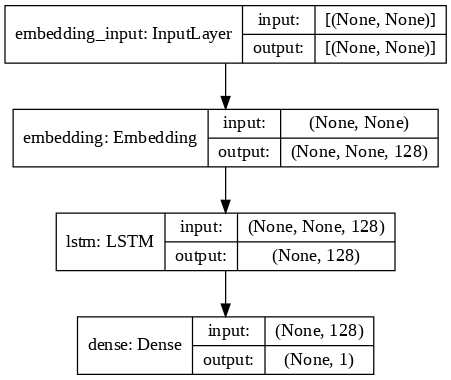

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=90) 

In [33]:
loss, acc = model.evaluate(X_test, Y_test, batch_size=32)

print('Test loss {0:.4f}:'.format(loss))
print('Test accuracy {0:.4f}:'.format(acc))

1431/1431 [==============================] - 17s 12ms/step - loss: 0.4707 - accuracy: 0.8373
Test loss 0.4707:
Test accuracy 0.8373:


In [34]:
y_pred = (model.predict(X_test)>=0.5).astype('int')

In [35]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [36]:
# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

[[18978  3971]
 [ 3477 19354]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84     22949
           1       0.83      0.85      0.84     22831

    accuracy                           0.84     45780
   macro avg       0.84      0.84      0.84     45780
weighted avg       0.84      0.84      0.84     45780



In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(Y_test, y_pred)
print('precision_score {0:.4f}'.format(p))
r = recall_score(Y_test, y_pred)
print('recall_score {0:.4f}'.format(r))
f1 = f1_score(Y_test, y_pred)
print('f1_score {0:.4f}'.format(f1))

precision_score 0.8298
recall_score 0.8477
f1_score 0.8386
